# AbDb Data Analysis

The metadata files have been downloaded from http://www.abybank.org/abdb/ using the "Complete Antibodies - Martin Numbering - Non Redundant (NR)" Dataset. (10.05.2022)

In [1]:
import pandas as pd
import yaml
import os
from ast import literal_eval

In [2]:
from abag_affinity.utils.config import read_yaml, get_data_paths, get_resources_paths

config = read_yaml("../../abag_affinity/config.yaml")
summary_path, pdb_path = get_resources_paths(config, "AbDb")

In [3]:
if os.path.exists(summary_path):
    abdb_df = pd.read_csv(summary_path)
else:
    abdb_df = pd.DataFrame()
abdb_df.head()

,abdb_filename,pdb,antibody_chains,antigen_chains,in_dataset,antigen_length
0,5IES_1.pdb,5ies,"['L', 'H']",['C'],True,167
1,3MJ9_1.pdb,3mj9,"['L', 'H']",['A'],True,229
2,5TFW_1.pdb,5tfw,"['L', 'H']",['O'],True,154
3,1F90_1.pdb,1f90,"['L', 'H']",['E'],True,9
4,4XI5_1.pdb,4xi5,"['L', 'H']","['B', 'A']",True,860


In [4]:
pdb_files = os.listdir(pdb_path)

print("Number of PDB Files >>>", len(pdb_files))

Number of PDB Files >>> 1229


In [5]:
pdb_files[:5]

['6N5E_1.pdb', '4TTD_1.pdb', '5B3J_2.pdb', '1QGC_1.pdb', '3CX5_1.pdb']

In [6]:
if len(abdb_df) == 0:
    abdb_df["abdb_filename"] = pdb_files
    pdb_ids = [pdb_file.split("_")[0].lower() for pdb_file in pdb_files]

    abdb_df["pdb"] = pdb_ids

In [7]:
abdb_df.head()

,abdb_filename,pdb,antibody_chains,antigen_chains,in_dataset,antigen_length
0,5IES_1.pdb,5ies,"['L', 'H']",['C'],True,167
1,3MJ9_1.pdb,3mj9,"['L', 'H']",['A'],True,229
2,5TFW_1.pdb,5tfw,"['L', 'H']",['O'],True,154
3,1F90_1.pdb,1f90,"['L', 'H']",['E'],True,9
4,4XI5_1.pdb,4xi5,"['L', 'H']","['B', 'A']",True,860


## PDB Files with no affinity value

Get all entries that are not part of the dataset_v1 (overlap of AbDb and SAbDab or Antibody Benchmark)

In [8]:
dataset_summary_path, _ = get_data_paths(config, "Dataset_v1")
dataset_df = pd.read_csv(dataset_summary_path)
dataset_df.head()

,index,pdb,abdb_file,antigen_type,antibody_chains,antigen_chains,affinity_method,temperature,calculated_temp,affinity,delta_g,test,validation
0,0,2r56,2R56_1.pdb,protein,"['I', 'M', 'H', 'L']","['B', 'A']",SPR,NaN,25.0,1.300000e-09,-12.120000,False,2
1,271,3l5x,3L5X_1.pdb,protein,"['H', 'L']",['A'],SPR,25,25.0,2.690000e-10,-13.050000,False,3
2,270,3sdy,3SDY_1.pdb,protein | protein,"['H', 'L']","['B', 'A']",Other,30,30.0,1.000000e-09,-12.480000,False,3
3,269,5i5k,5I5K_1.pdb,protein,"['X', 'Y', 'H', 'L']","['A', 'B']",SPR,NaN,25.0,1.760000e-11,-14.671746,False,3
4,268,3kr3,3KR3_1.pdb,protein,"['H', 'L']",['D'],SPR,25,25.0,4.900000e-11,-14.060000,False,2


In [9]:
abdb_df["in_dataset"] = False
abdb_df.loc[abdb_df["pdb"].isin(dataset_df["pdb"]), "in_dataset"] = True

In [10]:
print("PDB Files that are not in dataset v1 >>> {}".format(abdb_df["in_dataset"].count() - abdb_df["in_dataset"].sum()))

PDB Files that are not in dataset v1 >>> 804


In [11]:
import warnings
warnings.filterwarnings("ignore")
from abag_affinity.utils.pdb_reader import read_file

def get_chain_ids(row):
    pdb_id = row["pdb"]
    path = os.path.join(pdb_path, row["abdb_filename"])
    
    structure, header = read_file(pdb_id, path)
    
    chain_ids = []
    for chain in structure.get_chains():
        chain_ids.append(chain.id)
    return chain_ids

def check_LH_chains(row):
    if "L" in row["chains"] and "H" in row["chains"]:
        return True
    else:
        return False

In [12]:
from tqdm.auto import tqdm
tqdm.pandas()

if "antibody_chains" not in abdb_df.columns and "chains" not in abdb_df.columns:
    abdb_df["chains"] = abdb_df.apply(lambda row: get_chain_ids(row), axis=1)
if "antibody_chains" not in abdb_df.columns and "LH_exist" not in abdb_df.columns:
    abdb_df["LH_exist"] = abdb_df.apply(lambda row: check_LH_chains(row), axis=1)
    print("PDB Files where chain L and H do not exist >>> {}".format(abdb_df["LH_exist"].count() - abdb_df["LH_exist"].sum()))

In [13]:
if "antibody_chains" not in abdb_df.columns:
    abdb_df["antibody_chains"] = [["L", "H"] for i in abdb_df.index]

In [14]:
def get_antigen_chains(row):
    antigen_chains = set(row["chains"]) - set(row["antibody_chains"])
    return list(antigen_chains)

if "antigen_chains" not in abdb_df.columns:
    abdb_df["antigen_chains"] = abdb_df.apply(lambda row: get_antigen_chains(row), axis=1)

In [15]:
from Bio import PDB

def get_antigen_size(row):
    antigen_chains = row["antigen_chains"]
    if isinstance(antigen_chains, str):
        antigen_chains = literal_eval(antigen_chains)
    pdb_id = row["pdb"]
    path = os.path.join(pdb_path, row["abdb_filename"])
    
    structure, header = read_file(pdb_id, path)
    
    total_residues = 0
    total_non_residues = 0

    for chain_id in antigen_chains:
        chain = structure[0][chain_id]
        for residue in chain.get_residues():
            if PDB.is_aa(residue):
                total_residues += 1
            else:
                total_non_residues
                
    row["antigen_length"] = total_residues
    row["antigen_length_no_residues"] = total_non_residues

    return row


if "antigen_length" not in abdb_df.columns:
    abdb_df = abdb_df.apply(lambda row: get_antigen_size(row), axis=1)

In [16]:
abdb_df = abdb_df[["abdb_filename", "pdb", "antibody_chains", "antigen_chains", "in_dataset", "antigen_length"]]

abdb_df.head()

,abdb_filename,pdb,antibody_chains,antigen_chains,in_dataset,antigen_length
0,5IES_1.pdb,5ies,"['L', 'H']",['C'],True,167
1,3MJ9_1.pdb,3mj9,"['L', 'H']",['A'],True,229
2,5TFW_1.pdb,5tfw,"['L', 'H']",['O'],True,154
3,1F90_1.pdb,1f90,"['L', 'H']",['E'],True,9
4,4XI5_1.pdb,4xi5,"['L', 'H']","['B', 'A']",True,860


In [17]:
abdb_df = abdb_df.sort_values(by="in_dataset", ascending=False)

abdb_df.to_csv(summary_path, index=False)

## Analysis of computed Affinity values

In [41]:
computed_summary_path, pdb_paths = get_data_paths(config, "AbDb")
computed_summary_df = pd.read_csv(computed_summary_path)
computed_summary_df.head()

,pdb_id,file_name,bound_wildtype,unbound_wildtype,bound_wildtype vs unbound_wildtype,unbound_relaxed,bound_wildtype vs unbound_relaxed,bound_relaxed,relaxed_unbound,bound_relaxed vs relaxed_unbound,relaxed_unbound_relaxed,bound_relaxed vs relaxed_unbound_relaxed
0,4dkf,4DKF_1.pdb,379.520690,395.030194,-15.509503,-1184.429350,1563.950041,-1202.785804,-1164.603680,-38.182124,-1192.069617,-10.716187
1,4xtr,4XTR_1.pdb,-520.536914,-479.689938,-40.846976,-1597.445239,1076.908324,-1597.214508,-1547.099817,-50.114691,-1578.213271,-19.001237
2,6apd,6APD_1.pdb,512.068838,538.910937,-26.842099,-2088.225147,2600.293984,-2114.273220,-2051.618290,-62.654930,-2085.737296,-28.535924
3,4xaw,4XAW_1.pdb,-380.581699,-348.661883,-31.919816,-795.146841,414.565143,-824.861031,-773.189301,-51.671730,-788.835448,-36.025584
4,1s78,1S78_1.pdb,2479.984658,2507.889717,-27.905059,-2173.394433,4653.379091,-2233.880882,-2164.506800,-69.374082,-2204.752105,-29.128777


In [42]:
computed_summary_df[computed_summary_df["pdb_id"] == "1bj1"]

,pdb_id,file_name,bound_wildtype,unbound_wildtype,bound_wildtype vs unbound_wildtype,unbound_relaxed,bound_wildtype vs unbound_relaxed,bound_relaxed,relaxed_unbound,bound_relaxed vs relaxed_unbound,relaxed_unbound_relaxed,bound_relaxed vs relaxed_unbound_relaxed
341,1bj1,1BJ1_1.pdb,67.963765,107.846755,-39.882991,-1010.975707,1078.939472,-1038.19015,-976.510958,-61.679191,-1014.670377,-23.519772


In [21]:
delta_g_columns = ["bound_wildtype vs unbound_wildtype", "bound_wildtype vs unbound_relaxed", "bound_relaxed vs relaxed_unbound", "bound_relaxed vs relaxed_unbound_relaxed"]

In [22]:
computed_summary_df = computed_summary_df.set_index("pdb_id")

dataset_df_pdb = dataset_df.set_index("pdb")

joined_df = computed_summary_df.join(dataset_df_pdb, how="inner", lsuffix="_abdb")

abdb_df = abdb_df.set_index("pdb")

joined_df = joined_df.join(abdb_df, how="inner", lsuffix="_abdb")

joined_df = joined_df[["affinity", "delta_g", "temperature", "calculated_temp", "antigen_length","file_name"] + delta_g_columns ]

In [23]:
print("Number of Files with computed and measured affinity values", len(joined_df))

Number of Files with computed and measured affinity values 434


In [24]:
joined_df.head()

,affinity,delta_g,temperature,calculated_temp,antigen_length,file_name,bound_wildtype vs unbound_wildtype,bound_wildtype vs unbound_relaxed,bound_relaxed vs relaxed_unbound,bound_relaxed vs relaxed_unbound_relaxed
1ahw,NaN,-11.55,NaN,NaN,200,1AHW_1.pdb,2.489041,3550.709084,-67.788121,-21.886099
1bj1,3.400000e-09,-11.55,25,25.0,94,1BJ1_1.pdb,-39.882991,1078.939472,-61.679191,-23.519772
1bvk,1.400000e-08,-10.53,20,20.0,129,1BVK_1.pdb,-10.753682,2664.236355,-47.205769,-20.423557
1cz8,1.100000e-10,-14.12,37,37.0,94,1CZ8_1.pdb,-47.435179,1439.480981,-65.960237,-32.249865
1e6j,2.900000e-08,-10.28,NaN,25.0,210,1E6J_1.pdb,-35.444259,1571.665574,-82.495095,-20.332619


In [25]:
import numpy as np
from scipy import stats

correlations = {}

for col in delta_g_columns:
    # remove outiers 
    # outliers have a zscroe above 3
    mask = (np.abs(stats.zscore(joined_df[col])) < 2) & ~joined_df["calculated_temp"].isna() & (joined_df["antigen_length"] > 100)
        
    correlations[col] = {
        "affinity": joined_df[col][mask].corr(joined_df["affinity"][mask]),
        "delta_g": joined_df[col][mask].corr(joined_df["delta_g"][mask])
    }

In [26]:
best_combi = ()
best_correlation = 0

for type_ in correlations.keys():
    for measure in correlations[type_].keys():
        if correlations[type_][measure] > best_correlation:
            best_correlation = correlations[type_][measure]
            best_combi = (measure, type_)

In [27]:
print(best_combi, best_correlation)

('delta_g', 'bound_wildtype vs unbound_wildtype') 0.14519418445920945


<AxesSubplot:xlabel='delta_g', ylabel='bound_wildtype vs unbound_wildtype'>

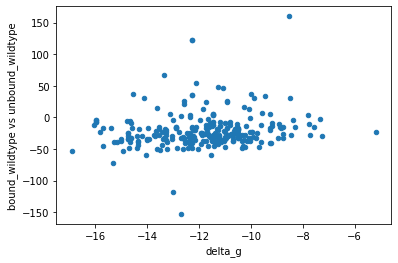

In [28]:
joined_df = joined_df[(np.abs(stats.zscore(joined_df[best_combi[1]])) < 2) & ~joined_df["calculated_temp"].isna() & (joined_df["antigen_length"] > 100)]
joined_df.plot.scatter(best_combi[0], best_combi[1])

##### Fit Linear Model to convert dg (REU) to affinity values

In [35]:
from sklearn.linear_model import LinearRegression
import numpy as np


X = joined_df.loc[:, [best_combi[1]]].values.reshape(-1, 1) 
Y = joined_df.loc[:, best_combi[0]].values.reshape(-1, 1) 

linear_regressor = LinearRegression()  
linear_regressor.fit(X, Y)  
joined_df["predicted_dg"] = linear_regressor.predict(X) 

In [36]:
joined_df[best_combi[0]].corr(joined_df["predicted_dg"])

0.0015786765066909973

<AxesSubplot:xlabel='delta_g', ylabel='predicted_dg'>

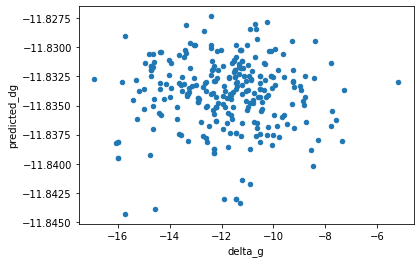

In [37]:
joined_df.plot.scatter("delta_g", "predicted_dg")

## Test IAM

In [32]:
import pyrosetta
from pyrosetta.rosetta.core.pose import Pose, add_comment, dump_comment_pdb, get_chain_from_chain_id
pyrosetta.init(extra_options="-mute all")

from Bio.PDB.PDBParser import PDBParser

parser = PDBParser(PERMISSIVE=3)

def load_pose(pdb_path: str) -> pyrosetta.Pose:
    pose = pyrosetta.pose_from_pdb(pdb_path)
    testPose = pyrosetta.Pose()
    testPose.assign(pose)
    return testPose

def get_partners(structure: Pose):

    chains = structure.get_chains()

    chains = [ chain.id for chain in chains]

    antibody_chains = ""
    antigen_chains = ""

    if "L" in chains:
        antibody_chains += "L"
        chains.remove("L")
    if "H" in chains:
        antibody_chains += "H"
        chains.remove("H")

    for chain in chains:
        antigen_chains += chain

    partners = antibody_chains + "_" + antigen_chains
    return partners

def get_dg_score(row):
    path = os.path.join(pdb_path, row["file_name"])

    pose = load_pose(path)

    structure = parser.get_structure("", path)
    partners = get_partners(structure)

    ia = pyrosetta.rosetta.protocols.analysis.InterfaceAnalyzerMover(partners)
    ia.apply(pose)


    return ia.get_interface_dG()


if "iam_dg_score" not in joined_df.columns:
    joined_df["iam_dg_score"] = joined_df.apply(lambda row: get_dg_score(row), axis=1)

PyRosetta-4 2020 [Rosetta PyRosetta4.conda.linux.CentOS.python37.Release 2020.10+release.46415fa3e9decb8b6e91a4e065c15543eb27a461 2020-03-05T09:09:24] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


KeyboardInterrupt: 